# Minplus algebra experiment

This code attempts to learn the 32D mixture prior
$J(x) = min(\frac{1}{2t\sigma_{1}}||x-\mu_{1}||^{2}, \frac{1}{2\sigma_{2}}||x-\mu_{2}||^{2})$
assuming we have access to training data $\{y_i, S(y_i)\} = min_{x \in \R} \ \{0.5||x-y_i||^{2}_{2} + J(x)\}\}$.

## Import modules 

In [1]:
import os
import numpy as np
import torch

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns

from network import LPN
from lib.utils import cvx
from lib.invert import invert

# set location
MODEL_DIR = "experiments/models/minplus_32D"
os.makedirs(MODEL_DIR, exist_ok=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# set random seeds
np.random.seed(1)
torch.manual_seed(1)

# plotting options
plt.rcParams.update({"text.usetex": False})
sns.set_theme()

# Utility functions and plotting tools

In [2]:
##############################
#----- Utlity functions -----#
##############################

# Elementary functions, with the axis specified.
def euclid_norm(x):
    return np.linalg.norm(x, ord = 2, axis = 1)


def inner_prod(x,y):
    return np.sum(x*y, axis = 1)

def euclid_norm_sq(x):
    if x.ndim == 1:
        return np.sum(x*x)
    return np.sum(x * x, axis=1)


def exp_func(x, gamma):
    ''' Proximal matching loss -- x |-> 1 - exp(-(||x||_{2}^{2}/gamma)^{2})
        for training learned proximal networks.
    '''
    return -torch.exp(-((torch.linalg.vector_norm(x, ord = 2, dim = 1)/ gamma) ** 2)) + 1.0


def hjsol_true(y,mu1,mu2,sigma1,sigma2):
    '''This function computes the solution S(y,t) of the Hamilton--Jacobi
    PDE for the minplus algebra example at t = 1.

    Args:
        y:      An n-dimensional numpy array of numbers
        mu1:    An n-dimensional numpy array of numbers
        mu2:    An n-dimensional numpy array of numbers
        sigma1: A positive number
        sigma2: A positive number
    Returns:
        hjsol:  An n-dimensional numpy array of numbers
    '''

    val1 = 0.5*pow(euclid_norm(y-mu1),2)/(1+sigma1)
    val2 = 0.5*pow(euclid_norm(y-mu2),2)/(1+sigma2)
    hjsol = np.minimum(val1,val2)
    return hjsol


def prior_true(y,mu1,mu2,sigma1,sigma2):
    '''This function computes the initial data of the Hamilton--Jacobi
    PDE for the minplus algebra example.

    Args:
        y:      An n-dimensional numpy array of numbers
        mu1:    An n-dimensional numpy array of numbers
        mu2:    An n-dimensional numpy array of numbers
        sigma1: A positive number
        sigma2: A positive number
    Returns:
        prior:  An n-dimensional numpy array of numbers
    '''
        
    val1 = 0.5*pow(euclid_norm(y-mu1),2)/sigma1
    val2 = 0.5*pow(euclid_norm(y-mu2),2)/sigma2
    prior = np.minimum(val1,val2)
    return prior


def cvx_true(y,mu1,mu2,sigma1,sigma2):
    '''This function computes 0.5*norm(y)_{2}^{2} - S(y,t) at t = 1.

    Args:
        y:      An n-dimensional numpy array of numbers
        mu1:    An n-dimensional numpy array of numbers
        mu2:    An n-dimensional numpy array of numbers
        sigma1: A positive number
        sigma2: A positive number
    Returns:
        cvx:  An n-dimensional numpy array of numbers
    '''

    cvx = 0.5*pow(euclid_norm(y),2) - hjsol_true(y,mu1,mu2,sigma1,sigma2)
    return cvx


def invert_prior(x, model, INVERT_MODE):
    ''' This function inverts the learned prior at a set of query points x.
    That is, we compute the points y for which nabla_{y}psi(y) = x, 
    where nabla_{y}*psi denotes the gradient of the LPN network.

        Args:
            x:              A numpy array of real numbers at which to invert the prior.
            model:          The trained LPN model object.
            INVERT_MODE:    The method for inverting the LPN network.

        Returns:    y:      The (approximate) set of points for which nabla_{y}psi(y) = x,
                            as a numpy array.
    '''

    y = invert(x,model,INVERT_MODE)
    return y


def evaluate_learned_prior(x, y, model, INVERT_MODE):
    ''' This function evaluates the learned prior at the points y obtained from
    inverting the prior, that is, for which nabla_{y}psi(y) = x, where nabla_{y}psi denotes
    the gradient of the LPN network.
    
    Args:
            x:              A numpy array of real numbers at which to invert the prior.
            model:          The trained LPN model object.
            INVERT_MODE:    The method for inverting the LPN network.

    Returns:    prior_est   The learned initial data (prior) of the HJ PDE at the points x.
    '''

    psi = model.scalar(torch.tensor(y).float().to(device)).squeeze(1).detach().cpu().numpy()
    prior_est = np.sum(x*y, axis = 1) - 0.5 * euclid_norm(x) - psi

    return prior_est

############################
#----- Plotting tools -----#
############################

def compute_square_cross_sections(a, spacing, dim):
    ''' Compute the cross sections (xi,0,...,0) and (0,xi,0,...,0) 
    on the grid [-a,a]^{dim} along the first and second dimensions.

    Args:       a:      A positive number
                spacing: Number of grid spacing along [-a,a]
                dim:    Dimension of the Hamilton--Jacobi PDE

    Returns:    xi:             The numpy array np.linspace(-a, a, spacing)

                x1_0_points:    k x dim numpy array of points, where
                                x_1_0_points[:,0] = np.linspace(-a, a, spacing)
                                with the rest of the entries equal to 0, and
                                k = xi.size

                x2_0_points:    k x dim numpy array of points, where
                                x_2_0_points[:,1] = np.linspace(-a, a, spacing)
                                with the rest of the entries equal to 0, and
                                k = xi.size
    '''

    xi = np.linspace(-a,a,spacing)
    grid = np.zeros((xi.size, dim))
    x1_0_points = np.copy(grid); x1_0_points[:,0] = xi
    x2_0_points = np.copy(grid); x2_0_points[:,1] = xi

    return xi, x1_0_points, x2_0_points


def cross_sections_plots(model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim):
    ''' Compare the true solution of the Hamilton--Jacobi PDE vs the LPN model
        on a square grid [-a,a]^{dim} by overlaying their cross sections along the first and second axes.

    Args:
            model:          The trained LPN model object.
            a:              Measure of the grid [-a,a]^{dim}
            spacing:        Number of points in the interval [-a,a]
            mu1, mu2:       n-dimensional numpy arrays for specifying the initial data
            sigma1, sigma2: Positive numbers for specifying the initial data
            INVERT_MODE:    The method for inverting the LPN network.
            dim:            Spatial dimension of the problem
    '''

    # Compute the cross sections in the first and second axes of the grid [-a,a]^{dim}. 
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)

    # Compute the true initial data and convex functions at the cross section points
    x1_0_cvx_true = cvx_true(x1_0_points,mu1,mu2,sigma1,sigma2)
    x2_0_cvx_true = cvx_true(x2_0_points,mu1,mu2,sigma1,sigma2)

    x1_0_prior_true = prior_true(x1_0_points,mu1,mu2,sigma1,sigma2)
    x2_0_prior_true = prior_true(x2_0_points,mu1,mu2,sigma1,sigma2)

    # Compute the learned initial data and convex functions at the cross section points
    x1_0_cvx_est = cvx(x1_0_points,model)
    x2_0_cvx_est = cvx(x2_0_points,model)
    
    y1 = invert(x1_0_points,model,INVERT_MODE)
    y2 = invert(x2_0_points,model,INVERT_MODE)
    x1_0_prior_est = evaluate_learned_prior(x1_0_points, y1, model, INVERT_MODE)
    x2_0_prior_est = evaluate_learned_prior(x2_0_points, y2, model, INVERT_MODE)

    # Plot cross sections of the convex function
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_cvx_est, "-", label="LPN")
    plt.plot(xi, x1_0_cvx_true, "--", label="Ref")
    plt.grid(True)
    plt.title(f"Cross sections ($x_1$,0) of the convex function, Dim {dim}")
    plt.xlabel('$x_1$')
    plt.ylabel('$Convex functions(x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_cvx_est, "-", label="LPN")
        plt.plot(xi, x2_0_cvx_true, "--", label="Ref")
        plt.grid(True)
        plt.title(f"Cross sections ($0,x_2$,0) of the convex function, Dim {dim}")
        plt.xlabel('$x_2$')
        plt.ylabel('$Convex functions (0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    

    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_prior_est, "-",label="LPN")
    plt.plot(xi, x1_0_prior_true, "-",label="Ref")
    plt.grid(True)
    plt.title(f"Cross sections ($x_1$,0) of the prior function,Dim {dim}")
    plt.xlabel('$x_1$')
    plt.ylabel('Prior functions ($x_1$,0)')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_prior_est, "-", label="LPN")
        plt.plot(xi, x2_0_prior_true, "-", label="Ref")
        plt.grid("on")
        plt.title(f"Cross sections ($0,x_2$,0) of the prior function,Dim {dim}")
        plt.xlabel('$x_1$')
        plt.ylabel('Prior functions ($0,x_2$,0)')
        plt.legend()
    plt.tight_layout()



def plot_all(model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim):

    # Plot cross sections of the HJ PDEs vs learned proximal network along the first and second dimensions.
    cross_sections_plots(model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim)

## Parameters

In [3]:
# Dimension
dim = 32

# Prior parameters
mu1 = np.zeros(dim); mu1[0] = 1.0;  sigma1 = 1.0
mu2 = np.ones(dim)/np.sqrt(dim);    sigma2 = 1.0

# Define the spatial grid [-a,a]^{dim}
a, spacing = 4, 100

# Number of samples from the solution we have access to
data_points = 40000
Iterations = 500000

# LPN model parameters
beta = 5       # beta of softplus
hidden = 256     # number of hidden units
layers = 2      # number of layers

# optimization algorithm to use for computing the prior (cvx_cg, cvx_gd)
INVERT_MODE = "cvx_gd"

## Generate training data

In [4]:
# Generate samples {yi} uniformly in the grid [-a,a]^{dim}
input = np.zeros((dim,data_points))

if(dim>1):
    for k in range(0,dim):
        input[k] = np.random.uniform(-a,a,data_points)
else:
    input = np.random.uniform(-a,a,data_points)

input = input.reshape(data_points,dim)

# Generate the samples
cvx_samples = cvx_true(input,mu1,mu2,sigma1,sigma2).reshape(data_points,-1)

# Recast the samples as tensors
input = torch.from_numpy(input).float()
cvx_samples = torch.from_numpy(cvx_samples).float()

# --- ADD THIS TO MOVE DATA TO GPU ---
input = input.to(device)
cvx_samples = cvx_samples.to(device)

## Training function

In [5]:
def single_iteration(i, data_points, lpn_model, optimizer, input,cvx_samples,loss_type, gamma_loss=None):
    # Compute the convex function from the input.
    cvx_out = lpn_model.scalar(input)

    # Calculate the loss function
    if loss_type == 2:
        loss = (cvx_out - cvx_samples).pow(2).sum() / data_points   # MSE loss
    elif loss_type == 1:
        loss = (cvx_out - cvx_samples).abs().sum() / data_points    # MAE loss
    elif loss_type == 0:
        loss = exp_func(cvx_out - cvx_samples, gamma_loss).mean()   # proximal matching loss
    else:
        raise ValueError("loss_type must be 0, 1, or 2")


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    lpn_model.wclip()

    # monitor
    # loss_lstar = exp_func(out - target, 0.1).mean()

    if not i % 5000:
        print("iteration", i, "loss", loss.item()) #, "loss_lstar", loss_lstar.item())

# Train

L2 loss -- Train

In [6]:
# initialize
lpn_model = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta).to(device)
optimizer = torch.optim.Adam(lpn_model.parameters(), lr=1e-3)

for i in range(1):
    single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type=2)

for g in optimizer.param_groups:
    g["lr"] = 1e-4
for i in range(Iterations):
    if (i % 100000 == 0) and (i > 0): 
        for g in optimizer.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")    
    single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type=2)


# save the model
torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, "l2.pth"))

iteration 0 loss 1861.7666015625
iteration 0 loss 57.827980041503906


iteration 5000 loss 0.5715116858482361


iteration 10000 loss 0.13130250573158264


iteration 15000 loss 0.06943320482969284


iteration 20000 loss 0.04684172570705414


iteration 25000 loss 0.0359419621527195


iteration 30000 loss 0.029056277126073837


iteration 35000 loss 0.024392712861299515


iteration 40000 loss 0.020710930228233337


iteration 45000 loss 0.01805555447936058


iteration 50000 loss 0.015780266374349594


iteration 55000 loss 0.014054724015295506


iteration 60000 loss 0.012709821574389935


iteration 65000 loss 0.011531032621860504


iteration 70000 loss 0.010528196580708027


iteration 75000 loss 0.009707718156278133


iteration 80000 loss 0.00899361353367567


iteration 85000 loss 0.008347030729055405


iteration 90000 loss 0.007836081087589264


iteration 95000 loss 0.007426813244819641


Learning rate decreased to 1e-05 at iteration 100000
iteration 100000 loss 0.006907629780471325


iteration 105000 loss 0.006651519797742367


iteration 110000 loss 0.006290058605372906


iteration 115000 loss 0.0059557692147791386


iteration 120000 loss 0.005614923778921366


iteration 125000 loss 0.005304398015141487


iteration 130000 loss 0.005073405336588621


iteration 135000 loss 0.004870275035500526


iteration 140000 loss 0.004656204953789711


iteration 145000 loss 0.004450666718184948


iteration 150000 loss 0.004293475765734911


iteration 155000 loss 0.004117829259485006


iteration 160000 loss 0.003951513674110174


iteration 165000 loss 0.0038221129216253757


iteration 170000 loss 0.0036884737201035023


iteration 175000 loss 0.0035471301525831223


iteration 180000 loss 0.003439779859036207


iteration 185000 loss 0.003338220529258251


iteration 190000 loss 0.003229835769161582


iteration 195000 loss 0.0031396218109875917


Learning rate decreased to 1.0000000000000002e-06 at iteration 200000
iteration 200000 loss 0.0030362934339791536


iteration 205000 loss 0.003014926565811038


iteration 210000 loss 0.0029166697058826685


iteration 215000 loss 0.0028231139294803143


iteration 220000 loss 0.00272300373762846


iteration 225000 loss 0.0026423344388604164


iteration 230000 loss 0.002561230445280671


iteration 235000 loss 0.0024814470671117306


iteration 240000 loss 0.002413314301520586


iteration 245000 loss 0.0023406962864100933


iteration 250000 loss 0.0022753302473574877


iteration 255000 loss 0.002216461580246687


iteration 260000 loss 0.0021504038013517857


iteration 265000 loss 0.002099092584103346


iteration 270000 loss 0.002042399486526847


iteration 275000 loss 0.0019844023045152426


iteration 280000 loss 0.0019419678719714284


iteration 285000 loss 0.0018918414134532213


iteration 290000 loss 0.0018512137467041612


iteration 295000 loss 0.0018042436568066478


Learning rate decreased to 1.0000000000000002e-07 at iteration 300000
iteration 300000 loss 0.0017667270731180906


iteration 305000 loss 0.0017537553794682026


iteration 310000 loss 0.001716110622510314


iteration 315000 loss 0.001679009641520679


iteration 320000 loss 0.0016436096047982574


iteration 325000 loss 0.0016096857143566012


iteration 330000 loss 0.0015769650926813483


iteration 335000 loss 0.0015453428495675325


iteration 340000 loss 0.0015147688100114465


iteration 345000 loss 0.0014851560117676854


iteration 350000 loss 0.0014564666198566556


iteration 355000 loss 0.0014285967918112874


iteration 360000 loss 0.0014015204505994916


iteration 365000 loss 0.001375157735310495


iteration 370000 loss 0.001349498750641942


iteration 375000 loss 0.001324527314864099


iteration 380000 loss 0.0013002530904486775


iteration 385000 loss 0.001276556751690805


iteration 390000 loss 0.0012534653069451451


iteration 395000 loss 0.001230869209393859


Learning rate decreased to 1.0000000000000004e-08 at iteration 400000
iteration 400000 loss 0.0012087697396054864


iteration 405000 loss 0.0012061512097716331


iteration 410000 loss 0.0012032744707539678


iteration 415000 loss 0.001200477359816432


iteration 420000 loss 0.001197731588035822


iteration 425000 loss 0.001195024698972702


iteration 430000 loss 0.0011923492420464754


iteration 435000 loss 0.0011897057993337512


iteration 440000 loss 0.0011870856396853924


iteration 445000 loss 0.0011844919063150883


iteration 450000 loss 0.0011819113278761506


iteration 455000 loss 0.0011793592711910605


iteration 460000 loss 0.0011768231634050608


iteration 465000 loss 0.0011743044015020132


iteration 470000 loss 0.0011718017049133778


iteration 475000 loss 0.0011693142587319016


iteration 480000 loss 0.0011668420629575849


iteration 485000 loss 0.001164378598332405


iteration 490000 loss 0.001161931431852281


iteration 495000 loss 0.0011595009127631783


L2 loss -- Plot

loss 60.15654754638672


loss -45.14649963378906


loss -125.44424438476562


loss -193.67245483398438


loss -251.41627502441406


loss -300.1053161621094


loss -340.9232177734375


loss -374.8680419921875


loss -402.8150634765625


loss -425.5382995605469


loss -443.71917724609375


loss -457.9652404785156


loss -468.8355407714844


loss -476.85955810546875


loss -482.5444030761719


loss -486.3722839355469


loss -488.79144287109375


loss -490.203125


loss -490.94757080078125


loss -491.29229736328125


loss -491.4270935058594


loss -491.46929931640625


loss -491.4791259765625


loss -491.48065185546875


loss -491.4808044433594


loss -491.4808349609375


loss -491.4808044433594


loss -491.4808044433594


loss -491.4808044433594


loss -491.4808044433594


loss -491.48077392578125


loss -491.4808044433594


loss -491.4808044433594


loss -491.4808349609375


loss -491.4808349609375


loss -491.48077392578125


loss -491.4808349609375


loss -491.4808349609375


loss -491.4808044433594


loss -491.48077392578125


final mse:  2.6659127683181794e-10
max, min: 6.835804 -7.8034034
loss 60.15654754638672


loss -52.559669494628906


loss -133.252685546875


loss -200.9056396484375


loss -258.4137268066406


loss -307.07745361328125


loss -347.98614501953125


loss -382.1465148925781


loss -410.46514892578125


loss -433.7243347167969


loss -452.5884094238281


loss -467.63446044921875


loss -479.38507080078125


loss -488.32806396484375


loss -494.92218017578125


loss -499.5971984863281


loss -502.7523498535156


loss -504.7527160644531


loss -505.9231872558594


loss -506.5402526855469


loss -506.82391357421875


loss -506.932861328125


loss -506.9658508300781


loss -506.97320556640625


loss -506.9742431640625


loss -506.974365234375


loss -506.974365234375


loss -506.974365234375


loss -506.974365234375


loss -506.974365234375


loss -506.974365234375


loss -506.9743957519531


loss -506.974365234375


loss -506.974365234375


loss -506.974365234375


loss -506.9743957519531


loss -506.974365234375


loss -506.974365234375


loss -506.974365234375


loss -506.974365234375


final mse:  4.060132507976988e-10
max, min: 7.729877 -8.06656


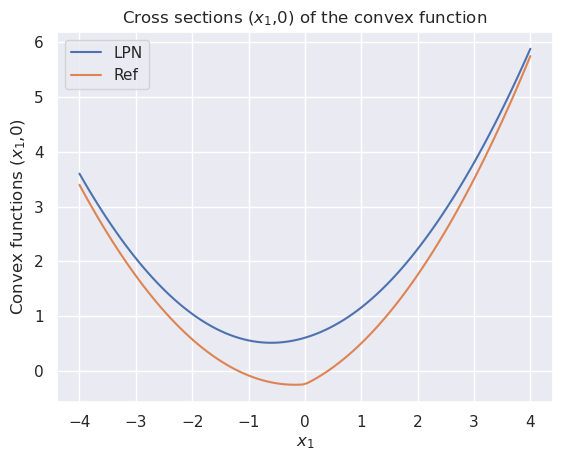

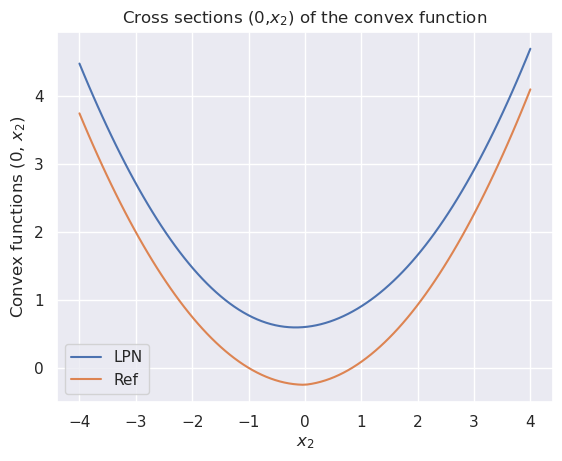

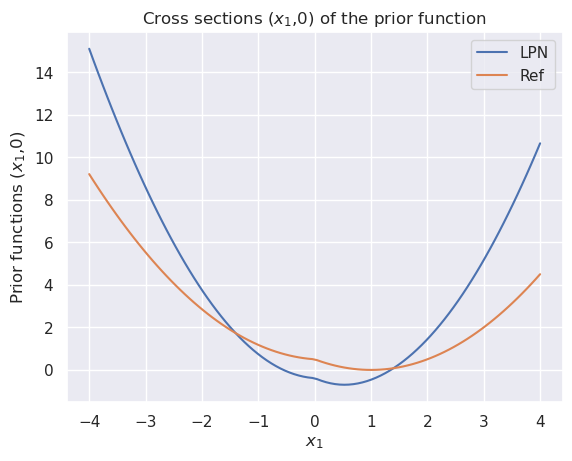

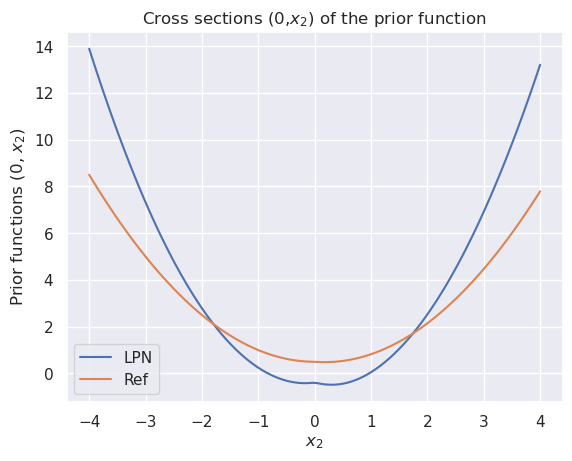

In [7]:
plot_all(lpn_model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim)

In [8]:
# --- Generate New Training Data for the Second LPN  ---
x_k_tensor = input.clone().to(device)
x_k_tensor.requires_grad_(True)

# Compute the gradient y_k = grad_x psi_theta(x_k, t=1)
# Get psi(x_k)
psi_x_k = lpn_model.scalar(x_k_tensor)

# Get gradient y_k = grad_psi(x_k)
y_k_tensor = lpn_model(x_k_tensor)

# Evaluate the "new" samples G_k = <y_k, x_k> - psi_theta(x_k, 1)
inner_prod_yk_xk = torch.sum(y_k_tensor * x_k_tensor, dim=1, keepdim=True)
G_samples_tensor_with_graph = inner_prod_yk_xk - psi_x_k
G_samples_tensor = G_samples_tensor_with_graph.detach().to(device) 

x_k_tensor = x_k_tensor.detach()
x_k_tensor.requires_grad_(False) 
y_k_tensor = y_k_tensor.detach()
y_k_tensor.requires_grad_(False)


# --- Train 2nd LPN 
print("\n--- Training Second LPN for Concave Quadratic Prior ---")
lpn_model_G = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta, eps=1e-3).to(device)
optimizer_G = torch.optim.Adam(lpn_model_G.parameters(), lr=1e-3)

for i in range(1):
     single_iteration(i, data_points, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

for g in optimizer_G.param_groups:
    g["lr"] = 1e-4 
for i in range(Iterations):
    if (i % 100000 == 0) and (i > 0): 
        for g in optimizer_G.param_groups:
            new_lr = g["lr"] / 5 #* 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")
    single_iteration(i, data_points, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_G.state_dict(), os.path.join(MODEL_DIR, "G_network_l2.pth"))
print("Training of LPN for G(x) complete and model saved.")


--- Training Second LPN for Concave Quadratic Prior ---
iteration 0 loss 1738.587158203125
iteration 0 loss 545.5783081054688


iteration 5000 loss 5.882257461547852


iteration 10000 loss 0.27238643169403076


iteration 15000 loss 0.10795019567012787


iteration 20000 loss 0.07340877503156662


iteration 25000 loss 0.056088510900735855


iteration 30000 loss 0.045048609375953674


iteration 35000 loss 0.03853312507271767


iteration 40000 loss 0.03307481110095978


iteration 45000 loss 0.02961089462041855


iteration 50000 loss 0.026398565620183945


iteration 55000 loss 0.023867178708314896


iteration 60000 loss 0.021857427433133125


iteration 65000 loss 0.019878052175045013


iteration 70000 loss 0.01846957579255104


iteration 75000 loss 0.017121125012636185


iteration 80000 loss 0.016045663505792618


iteration 85000 loss 0.29372504353523254


iteration 90000 loss 0.014091341756284237


iteration 95000 loss 0.013213166035711765


Learning rate decreased to 2e-05 at iteration 100000
iteration 100000 loss 0.012282726354897022


iteration 105000 loss 0.011688717640936375


iteration 110000 loss 0.0110700698569417


iteration 115000 loss 0.010435685515403748


iteration 120000 loss 0.009949562139809132


iteration 125000 loss 0.009361217729747295


iteration 130000 loss 0.008905265480279922


iteration 135000 loss 0.008440357632935047


iteration 140000 loss 0.008080024272203445


iteration 145000 loss 0.0076949261128902435


iteration 150000 loss 0.007411940023303032


iteration 155000 loss 0.007079428527504206


iteration 160000 loss 0.006836536806076765


iteration 165000 loss 0.006549731828272343


iteration 170000 loss 0.006319914944469929


iteration 175000 loss 0.006107068154960871


iteration 180000 loss 0.005861655808985233


iteration 185000 loss 0.005662882700562477


iteration 190000 loss 0.00546245276927948


iteration 195000 loss 0.005301051307469606


Learning rate decreased to 4.000000000000001e-06 at iteration 200000
iteration 200000 loss 0.005114948842674494


iteration 205000 loss 0.004976246505975723


iteration 210000 loss 0.004819026216864586


iteration 215000 loss 0.004672547802329063


iteration 220000 loss 0.004529251717031002


iteration 225000 loss 0.00439265463501215


iteration 230000 loss 0.004281321540474892


iteration 235000 loss 0.004157492890954018


iteration 240000 loss 0.004047445487231016


iteration 245000 loss 0.003924963995814323


iteration 250000 loss 0.003826146712526679


iteration 255000 loss 0.0037282882258296013


iteration 260000 loss 0.0036259309854358435


iteration 265000 loss 0.0035252338275313377


iteration 270000 loss 0.003435013582929969


iteration 275000 loss 0.0033411094918847084


iteration 280000 loss 0.0032689727377146482


iteration 285000 loss 0.003189952578395605


iteration 290000 loss 0.0031146847177296877


iteration 295000 loss 0.003048880025744438


Learning rate decreased to 8.000000000000002e-07 at iteration 300000
iteration 300000 loss 0.002971428679302335


iteration 305000 loss 0.0029511332977563143


iteration 310000 loss 0.002870833734050393


iteration 315000 loss 0.002789487363770604


iteration 320000 loss 0.0027153147384524345


iteration 325000 loss 0.002640648279339075


iteration 330000 loss 0.0025744601152837276


iteration 335000 loss 0.002510602818801999


iteration 340000 loss 0.0024501322768628597


iteration 345000 loss 0.002392191905528307


iteration 350000 loss 0.0023378252517431974


iteration 355000 loss 0.0022875654976814985


iteration 360000 loss 0.002236509695649147


iteration 365000 loss 0.002183443633839488


iteration 370000 loss 0.0021350467577576637


iteration 375000 loss 0.0020891735330224037


iteration 380000 loss 0.0020454947371035814


iteration 385000 loss 0.002005730289965868


iteration 390000 loss 0.0019671020563691854


iteration 395000 loss 0.0019279653206467628


Learning rate decreased to 1.6000000000000003e-07 at iteration 400000
iteration 400000 loss 0.001884915865957737


iteration 405000 loss 0.0018560325261205435


iteration 410000 loss 0.0018188804388046265


iteration 415000 loss 0.0017834427999332547


iteration 420000 loss 0.0017493546474725008


iteration 425000 loss 0.0017164216842502356


iteration 430000 loss 0.0016845546197146177


iteration 435000 loss 0.0016536943148821592


iteration 440000 loss 0.0016236944356933236


iteration 445000 loss 0.001594477565959096


iteration 450000 loss 0.001566023682244122


iteration 455000 loss 0.0015383199788630009


iteration 460000 loss 0.0015112895052880049


iteration 465000 loss 0.001484885928221047


iteration 470000 loss 0.001459103194065392


iteration 475000 loss 0.0014340071938931942


iteration 480000 loss 0.001409509452059865


iteration 485000 loss 0.0013856294099241495


iteration 490000 loss 0.0013623356353491545


iteration 495000 loss 0.001339560141786933


Training of LPN for G(x) complete and model saved.



--- Plotting Estimated Prior J(x) from 2nd LPN---


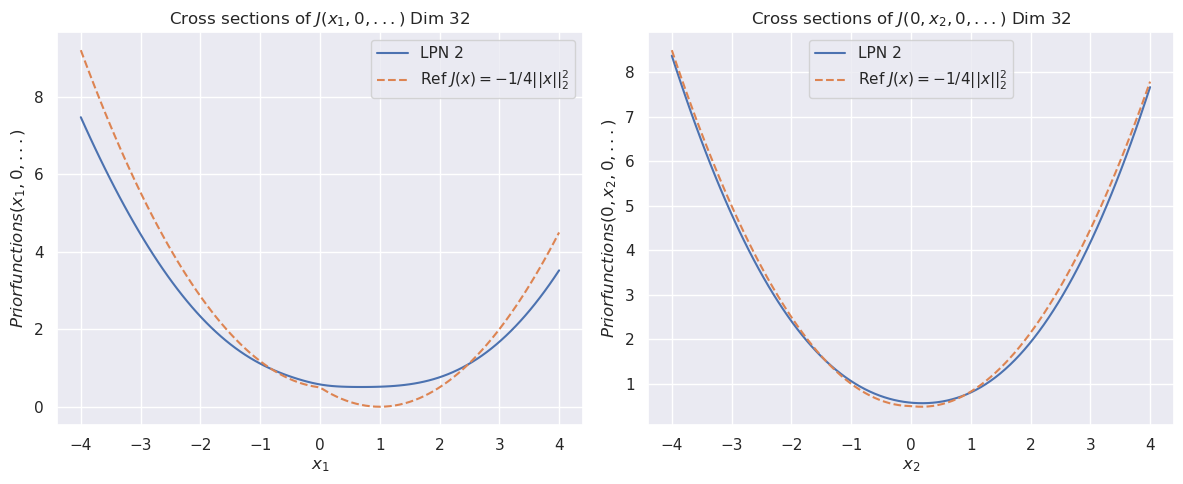

In [9]:
def evaluate_learned_J_G_network(x_points, model_G):
    """
    Evaluates the learned prior J(x) using the trained G(x) network.
    J(x) = G(x) - 0.5 * ||x||^2
    """
    # Convert to tensor
    x_tensor = torch.from_numpy(x_points).float().to(device)
    
    G_x = model_G.scalar(x_tensor)
    x_norm_sq_np = euclid_norm_sq(x_points)
    x_norm_sq_tensor = torch.from_numpy(x_norm_sq_np).float().to(device).reshape(-1, 1)
    J_est = G_x - 0.5 * x_norm_sq_tensor
    
    # Convert back to numpy
    J_est_np = J_est.detach().cpu().numpy().flatten()
    
    return J_est_np

def plot_J_G_network(model_G, a, spacing, dim,mu1,mu2,sigma1,sigma2):
    """Plots the cross-sections of the estimated prior J(x) from the G network."""
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    # True Prior
    x1_0_J_true = prior_true(x1_0_points,mu1,mu2,sigma1,sigma2)
    if dim > 1:
        x2_0_J_true = prior_true(x2_0_points,mu1,mu2,sigma1,sigma2)
    else:
        x2_0_J_true = x1_0_J_true
        
    x1_0_J_G_est = evaluate_learned_J_G_network(x1_0_points, model_G)
    if dim > 1:
        x2_0_J_G_est = evaluate_learned_J_G_network(x2_0_points, model_G)
    else:
        x2_0_J_G_est = x1_0_J_G_est
    
    print("\n--- Plotting Estimated Prior J(x) from 2nd LPN---")
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_G_est, "-", label="LPN 2")
    plt.plot(xi, x1_0_J_true, "--", label="Ref $J(x)=-1/4||x||_2^2$")
    plt.grid(True)
    plt.title(f"Cross sections of $J(x_1,0,...)$ Dim {dim}")
    plt.xlabel('$x_1$')
    plt.ylabel('$Prior functions (x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_G_est, "-", label="LPN 2")
        plt.plot(xi, x2_0_J_true, "--", label="Ref $J(x)=-1/4||x||_2^2$")
        plt.grid(True)
        plt.title(f"Cross sections of $J(0,x_2,0,...)$ Dim {dim}")
        plt.xlabel('$x_2$')
        plt.ylabel('$Prior functions (0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    
# --- Execute Plotting ---
plot_J_G_network(lpn_model_G, a, spacing, dim,mu1,mu2,sigma1,sigma2)